In [1]:
import pickle
from ast import literal_eval
import pandas as pd
import numpy as np
import random
import os

from sklearn import metrics
from sklearn.cluster import SpectralClustering

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import textwrap

from scipy.spatial.distance import squareform

from sklearn.manifold import TSNE
import umap

/opt/anaconda3/envs/tf-apple/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
phrog_palette = {
    'DNA, RNA and nucleotide metabolism': 'red',
    'connector': 'blue',
    'head and packaging': 'green',
    'integration and excision': 'pink',
    'lysis': 'gray',
    'moron, auxiliary metabolic gene and host takeover': 'brown',
    'other': 'purple',
    'tail': 'darkorange',
    'transcription regulation': 'cyan'
}

In [3]:
df = pd.read_csv('phrog_family_vectors_data.csv')

In [4]:
phrog_metadata = pd.read_csv('../PHROG_index_revised_v4_10292022.csv')

In [5]:
phrog_dists = phrog_metadata.merge(right=df, how='outer', on='#phrog')
phrog_dists = phrog_dists[~phrog_dists['revised_category_v4'].isin(['unknown function'])]
phrog_dists.sort_values(by='revised_category_v4', inplace=True)

In [6]:
cs = set(phrog_dists['revised_category_v4'])

In [7]:
cat_vs_cat_dists = []
cat_vs_cat = {}
for i in range(len(cs)):
    c = list(cs)[i]
    dic = {}
    d = phrog_dists[phrog_dists['revised_category_v4'] == c]
    
    for j in range(len(cs)):
        
        if i == j:
            continue
        
        cc = list(cs)[j]
        nd = phrog_dists[phrog_dists['revised_category_v4'] == cc]

        c_vecs = []
        nd_vecs = []

        for ph in d['#phrog']:
            c_vecs.append(pickle.load(open('phrog_centroid/{0}.pkl' ''.format(ph), 'rb')))

        for ph in nd['#phrog']:
            nd_vecs.append(pickle.load(open('phrog_centroid/{0}.pkl' ''.format(ph), 'rb')))

        c_vecs = np.array(c_vecs)
        nd_vecs = np.array(nd_vecs)

        sims = metrics.pairwise.cosine_similarity(c_vecs, nd_vecs)



        m_sims = np.mean(sims, axis=0)
        mm_sims = np.mean(m_sims, axis=0)

        cat_vs_cat_dists.append(zip([c]*len(m_sims), [cc]*len(m_sims), m_sims))
        
        if j > i:
            dic[cc] = {'weight': mm_sims}
    if len(dic) > 0:
        cat_vs_cat[c] = dic

cat_vs_cat_dists = [x for y in cat_vs_cat_dists for x in y]
df_cat_vs_cat_dists = pd.DataFrame(cat_vs_cat_dists, columns=['label1', 'label2', 'similarity'])
df_cat_vs_cat_dists.sort_values(by='label1', inplace=True)

In [8]:
pairwise_similarity_dict = {(k,v):cat_vs_cat[k][v]['weight'] for k in cat_vs_cat.keys() for v in cat_vs_cat[k].keys()}

In [9]:
dist_list = [dist[1] for dist in pairwise_similarity_dict.items()]

In [10]:
df_clustering = pd.DataFrame(squareform(dist_list), index=list(cs), columns=list(cs))

In [11]:
clustering = SpectralClustering(n_clusters=2, affinity='precomputed').fit(df_clustering)

# figure 4a

In [12]:
l_v = []
for c in cs:
    d = phrog_dists[phrog_dists['revised_category_v4'] == c]
    for ph in d['#phrog']:
        v = pickle.load(open('phrog_centroid/{0}.pkl' ''.format(ph), 'rb'))
        l_v.append((c, v))

labels = [x[0] for x in l_v]
vectors = [x[1] for x in l_v]

labels = np.array(labels)
vectors = np.array(vectors)

In [13]:
umap_2d = umap.UMAP(n_components=2, init='random', random_state=123)
umapper = umap_2d.fit_transform(vectors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
df_u = pd.DataFrame()
df_u['label'] = labels
df_u['comp1'] = umapper[:,0]
df_u['comp2'] = umapper[:,1]

In [15]:
plt.rcParams.update({'font.size': 24})

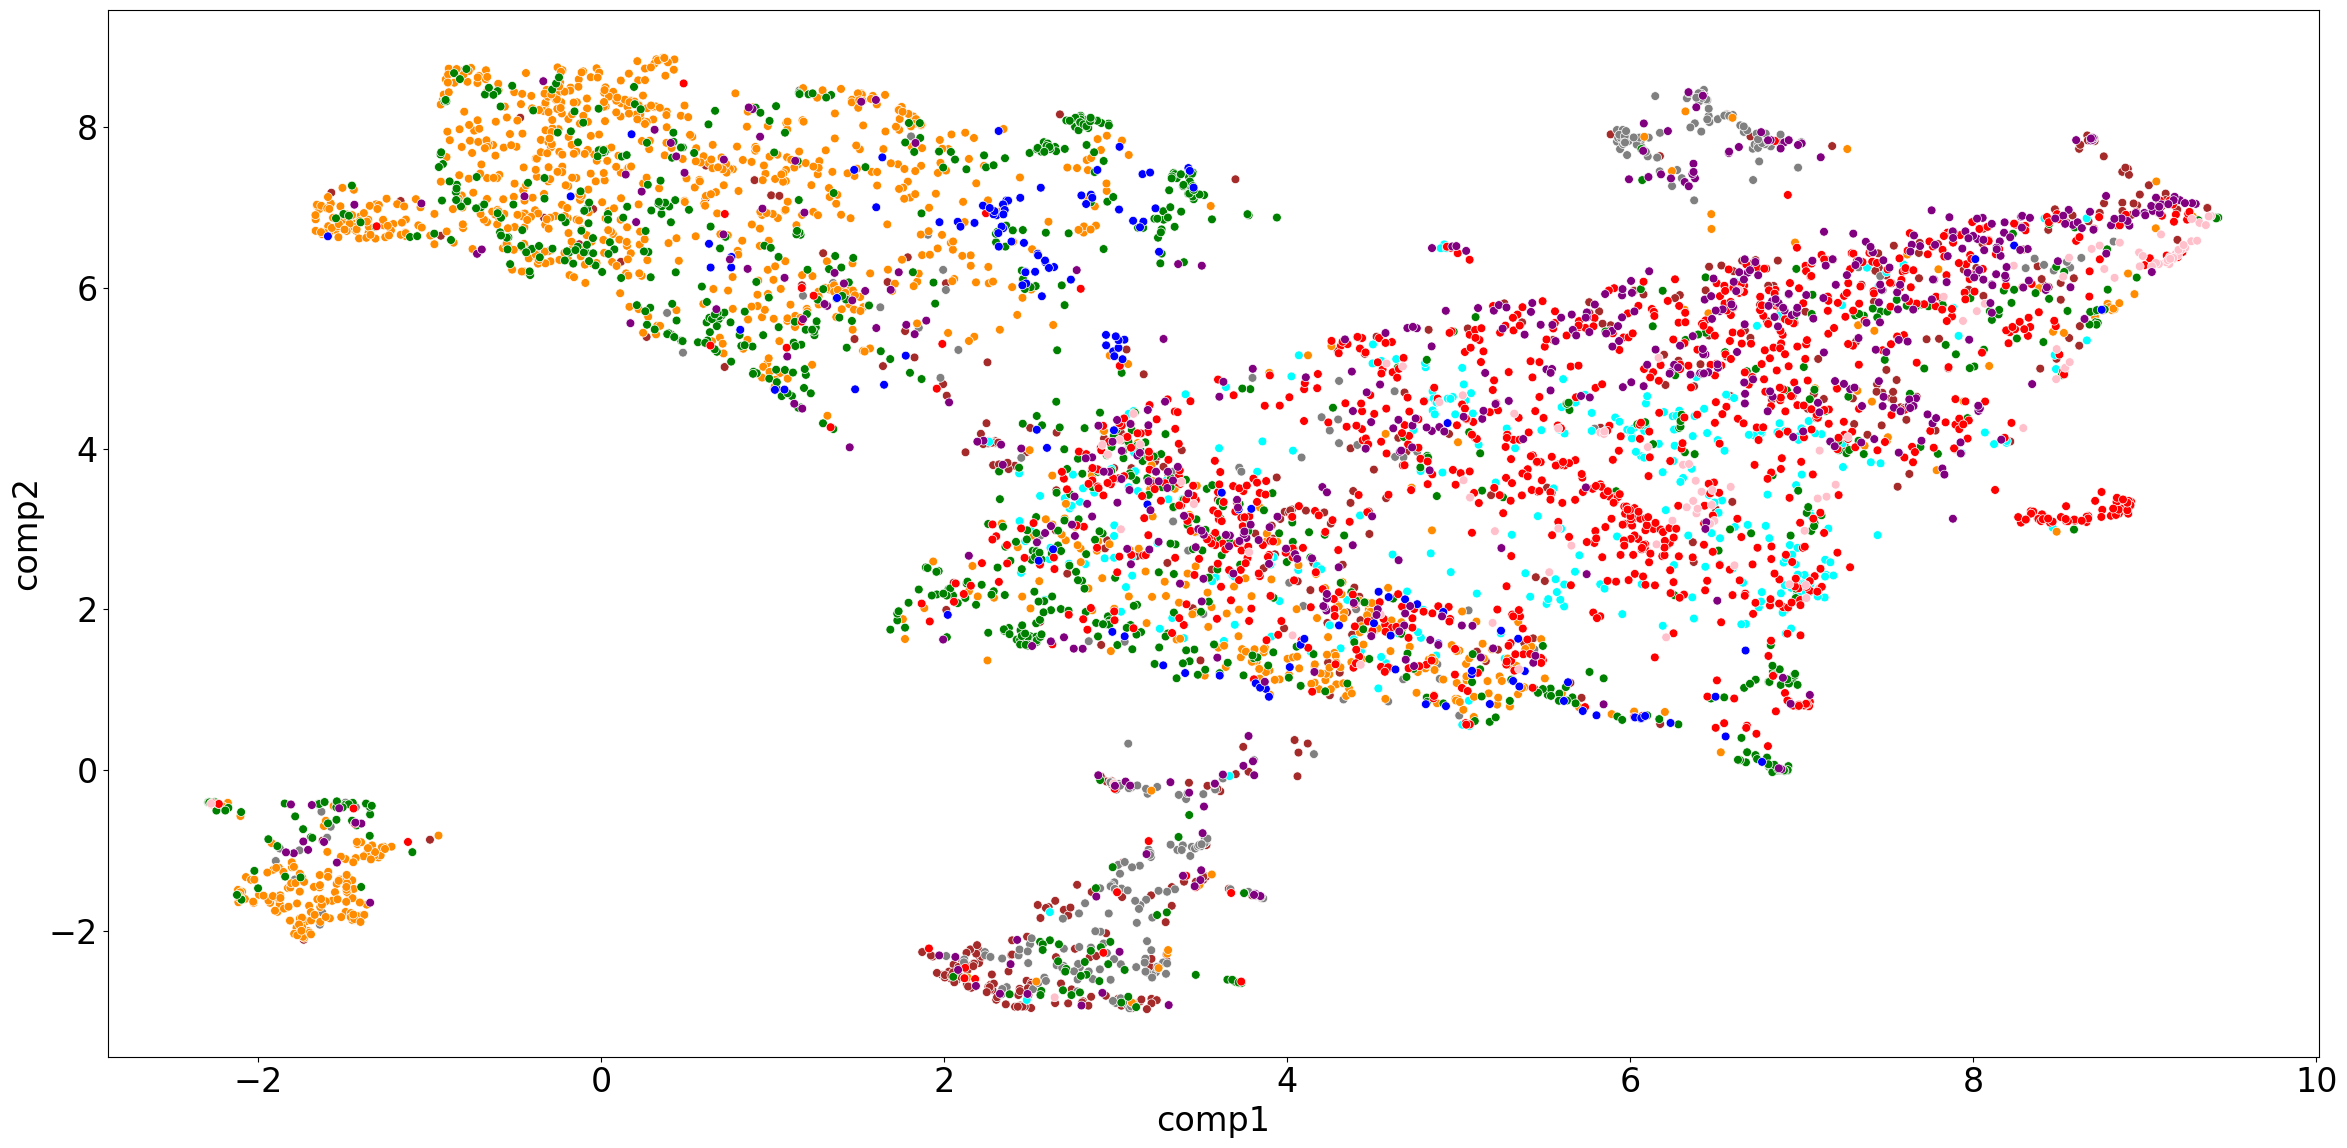

In [16]:
plt.figure(figsize=(24,12))
ax = sns.scatterplot(x='comp1', y='comp2', hue=df_u.label.tolist(),
                palette=phrog_palette, 
                legend=False,
                s=40,
                data=df_u)


plt.tight_layout()
plt.savefig('family_vector_centroid_umap.png', dpi=300)

# figure 4c

In [17]:
cluster_assignment = {}
for i in range(len(cs)):
    # to make sure that the tail containing cluster is cluster1
    cluster_assignment[list(cs)[i]] = clustering.labels_[i]

In [18]:
def label_spectral_cluster(label: str, cluster_assignment: dict):
    return 'cluster{0}' ''.format(cluster_assignment[label]+1)

df_u['spectral_cluster'] = [label_spectral_cluster(label=x, cluster_assignment=cluster_assignment) for x in df_u['label']]

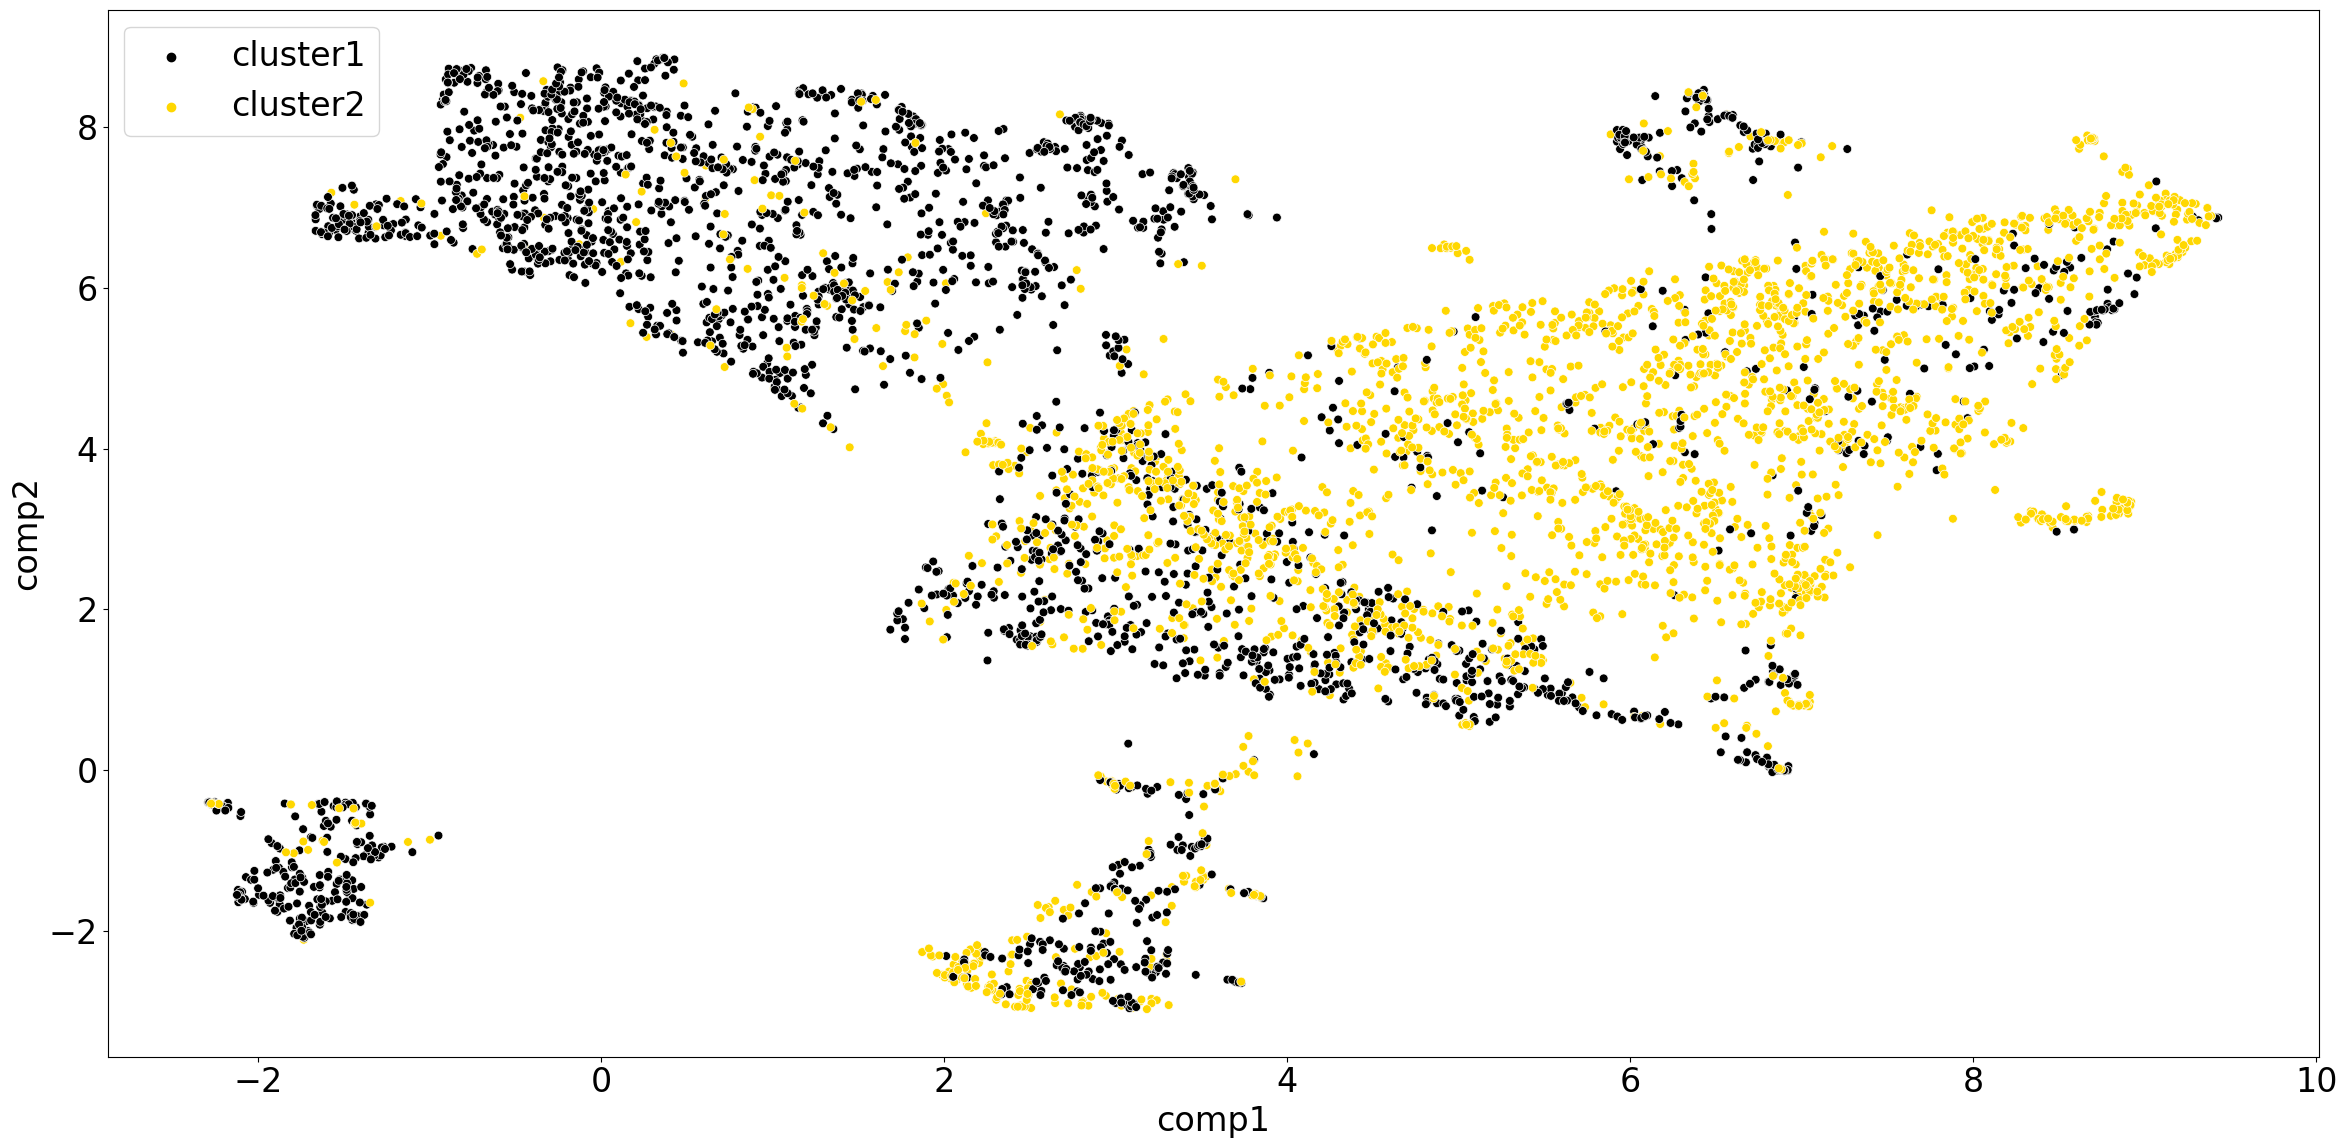

In [19]:
plt.figure(figsize=(24,12))
ax = sns.scatterplot(x='comp1', y='comp2', hue=df_u.spectral_cluster.tolist(),
                palette=['black', 'gold'],
                hue_order=['cluster1', 'cluster2'],
                s=40,
                data=df_u)

plt.tight_layout()
plt.savefig('family_vector_centroid_grouped_spectral_clustering_umap.png', dpi=300)